## Visualize and evaluate raw, aligned and placed detections

In [1]:
import os
import numpy as np
import pandas as pd
from PIL import Image
from ast import literal_eval

In [2]:
import matplotlib.pyplot as plt

/home/tobias/.virtualenvs/pytorch/local/lib/python2.7/site-packages/matplotlib/__init__.py:907: MatplotlibDeprecationWarning: The backend.qt4 rcParam was deprecated in version 2.2.  In order to force the use of a specific Qt binding, either import that binding first, or set the QT_API environment variable.
  mplDeprecation)


In [3]:
# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [4]:
relative_path = '../../'
# ensure that parent path is on the python path in order to have all packages available
import sys, os
parent_path = os.path.join(os.getcwd(), relative_path)
parent_path = os.path.realpath(parent_path)  # os.path.abspath(...)
sys.path.insert(0, parent_path)

In [5]:
from lib.evaluations.config import cfg, cfg_from_file, cfg_from_list

from lib.transliteration.sign_labels import get_lbl2lbl
from lib.transliteration.mzl_util import get_unicode_comp
from lib.visualizations.run_visualize_tpfp import gen_fptp_visuals

## Setup

### Config dataset

In [6]:
ds_version = ['test'] # test, train, test_full, saa06, ...
 
# use custom selection of segments
use_custom_list = False

### Config detection source

In [7]:
detection_src = ['detection', 'detection_pp', 'alignment']

# select if to use raw detections or aligned & placed detections
src_used = detection_src[0]   # 0, 2

# use with cond_hypos in order to check performance of placed detections
keep_only_placed = False  

In [8]:
if src_used == 'alignment':
    ### alignments (pre-computed )
    vis_score_th = 0.01 
    apply_nms = False 
    
    model_versions = ['v191ft01_hp04', 'v191ft01_hp04_cond_hypos']

else:
    ### detections (in place)
    vis_score_th = 0.2  # for detection: 0.3
    apply_nms = True  # for detection: True
    
    keep_only_imputed = False  # default for detections
    
    model_versions = ['v191ft01'] 

### Config visualization

In [9]:
# for visualization
visualize_TPFP = False  # full tablet visuals

plot_TPFP_signs = True  # plot and store individual signs

single_column = True

In [10]:
# select classes to show

# 𒌓 𒉿 𒁍 𒋼 𒂟
# 39, 155, 87,  18, 105,
# [596, 598, 580, 589, 612],
classes_to_show = [39, 155, 87,  18, 105]

# 𒈠 𒆷 𒀳 𒋗 𒆠 𒇻
# 13, 108, 228,  96, 100,  82,
# [552, 89, 90, 567, 737, 812],
classes_to_show = [13, 108, 228, 96, 100, 82]

# 𒄿 𒉺 𒁲 𒀾 𒄯
# 80, 113, 77,  57, 187
#[252, 464, 736, 548, 644]
classes_to_show = [80, 113, 77,  57, 187]

# 𒂊 𒌑 𒅀 𒆗
# 19, 30, 84, 126
# [498, 490, 260, 496]
classes_to_show = [19, 30, 84, 126]


classes_to_show = [30]

<a id='complconf'>Config Completeness</a>

[Jump to results](#results)

### Storage options

In [11]:
store_tfps_figures = False

use_seperate_model_folders = False  # for each model create corresponding folder

if use_seperate_model_folders:
    exp_name = None
else:
    exp_name = "trial_01"

### Other configs

In [12]:
# nms config
#apply_nms = False  # for detection: True
nms_th = 0.3  # 0.3

In [13]:
# set thresholds for own evaluation
eval_tp_thresh = 0.5  # 0.4 0.5 

eval_bg_thresh = 0.2  # 0.2 seems better choice for cuneiform, default is 0.1

pre_config = ['TEST.TP_MIN_OVERLAP', 0.5]
# ensure config is loaded before dependent functions are used/ instantiated
cfg_from_list(pre_config)

In [14]:
# control completeness filter
filter_completeness = False

compl_thresh = -1  # 0, 2, 3, 4, 5, 6  disable: -1
ncompl_thresh = 10 # 10, 15, 20   disable: -1

### Load label list

In [15]:
path_to_lbl_file = relative_path + 'data/newLabels.json'
lbl2lbl = get_lbl2lbl(path_to_lbl_file)

### Load MesZL cuneiform

In [16]:
num_classes = 240

In [17]:
cunei_mzl_df = pd.read_csv('{}data/cunei_mzl.csv'.format(relative_path), index_col=0)
cunei_mzl_df = cunei_mzl_df[cunei_mzl_df.num_cpts > 0]  # avoid mzl idx without codepoint
cunei_mzl_df = cunei_mzl_df.groupby('MesZL', sort=False, as_index=False).first()  # deal with multiple versions

In [18]:
print(get_unicode_comp(490, cunei_mzl_df))

𒌑


### Load Cuneiform Font for Visual

In [19]:
import matplotlib.font_manager as fm

# locate Assurbanipal.ttf
cunei_font_path = filter(lambda x: 'Assurbanipal' in x, fm.findSystemFonts(fontpaths=None, fontext='ttf'))[0]
font_prop = fm.FontProperties(fname=cunei_font_path, size=24)

## Visualize 

v191ft01
Setup dataset spanning 1 collections with 1610 annotations [16 segments, 16 indices]


/home/tobias/.virtualenvs/pytorch/local/lib/python2.7/site-packages/torch/cuda/__init__.py:117: UserWarning: 
    Found GPU1 GeForce GTX 770 which is of cuda capability 3.0.
    PyTorch no longer supports this GPU because it is too old.
    
  warnings.warn(old_gpu_warn % (d, name, major, capability[1]))
  0%|          | 0/16 [00:00<?, ?it/s]

(0, 'ND02486', 'Rev')


  6%|▋         | 1/16 [00:00<00:05,  2.61it/s]

mAP 0.7241 | global AP: 0.7382 | mAP (align): 0.84
total_tp: 34 | total_fp: 7 [15] | acc: 0.83
(1, 'ND02486', 'Obv')


 12%|█▎        | 2/16 [00:00<00:05,  2.52it/s]

mAP 0.8737 | global AP: 0.882 | mAP (align): 0.9339
total_tp: 41 | total_fp: 7 [14] | acc: 0.85
(2, 'K08396', 'Rev')


 19%|█▉        | 3/16 [00:02<00:09,  1.38it/s]

mAP 0.8099 | global AP: 0.8523 | mAP (align): 0.8898
total_tp: 151 | total_fp: 57 [77] | acc: 0.73
(3, 'K08396', 'Obv')


 25%|██▌       | 4/16 [00:03<00:10,  1.16it/s]

mAP 0.8198 | global AP: 0.8632 | mAP (align): 0.9412
total_tp: 102 | total_fp: 30 [57] | acc: 0.77
(4, 'BM099070', 'Obv')


 31%|███▏      | 5/16 [00:03<00:08,  1.27it/s]

mAP 0.6198 | global AP: 0.5848 | mAP (align): 0.8006
total_tp: 34 | total_fp: 18 [32] | acc: 0.65
(5, 'P334926', 'Obv')


 38%|███▊      | 6/16 [00:04<00:08,  1.20it/s]

mAP 0.8779 | global AP: 0.8207 | mAP (align): 0.9049
total_tp: 144 | total_fp: 19 [28] | acc: 0.88
(6, 'P334926', 'Rev')


 44%|████▍     | 7/16 [00:05<00:07,  1.20it/s]

mAP 0.8864 | global AP: 0.8972 | mAP (align): 0.975
total_tp: 24 | total_fp: 3 [9] | acc: 0.89
(7, 'P334932', 'Obv')


 50%|█████     | 8/16 [00:06<00:06,  1.17it/s]

mAP 0.7463 | global AP: 0.7845 | mAP (align): 0.9017
total_tp: 98 | total_fp: 12 [20] | acc: 0.89
(8, 'P334932', 'Rev')


 56%|█████▋    | 9/16 [00:07<00:05,  1.18it/s]

mAP 0.7488 | global AP: 0.7797 | mAP (align): 0.9189
total_tp: 38 | total_fp: 9 [17] | acc: 0.81
(9, 'P336128', 'Obv')


 62%|██████▎   | 10/16 [00:08<00:05,  1.16it/s]

mAP 0.7288 | global AP: 0.6881 | mAP (align): 0.8097
total_tp: 137 | total_fp: 41 [47] | acc: 0.77
(10, 'P336128', 'Rev')


 69%|██████▉   | 11/16 [00:09<00:04,  1.16it/s]

mAP 0.7675 | global AP: 0.7699 | mAP (align): 0.8869
total_tp: 79 | total_fp: 17 [25] | acc: 0.82
(11, 'P336150', 'Obv')


 75%|███████▌  | 12/16 [00:10<00:03,  1.15it/s]

mAP 0.3946 | global AP: 0.408 | mAP (align): 0.4626
total_tp: 110 | total_fp: 20 [33] | acc: 0.85
(12, 'P336150', 'Rev')

 81%|████████▏ | 13/16 [00:11<00:02,  1.18it/s]


mAP 0.8571 | global AP: 0.7996 | mAP (align): 0.9231
total_tp: 15 | total_fp: 5 [12] | acc: 0.75
(13, 'P336158', 'Rev')


 88%|████████▊ | 14/16 [00:11<00:01,  1.22it/s]

mAP 0.7258 | global AP: 0.6851 | mAP (align): 0.8295
total_tp: 45 | total_fp: 14 [27] | acc: 0.76
(14, 'P336158', 'Obv')


 94%|█████████▍| 15/16 [00:11<00:00,  1.27it/s]

mAP 0.5923 | global AP: 0.4646 | mAP (align): 0.7897
total_tp: 24 | total_fp: 12 [28] | acc: 0.67
(15, 'K09237Vs', 'Obv')


100%|██████████| 16/16 [00:12<00:00,  1.24it/s]

mAP 0.9236 | global AP: 0.9176 | mAP (align): 0.9669
total_tp: 107 | total_fp: 12 [21] | acc: 0.9


['test'] | v191ft01
RESULTS ON FULL COLLECTION :
mAP 0.6651 | global AP: 0.7202 | mAP (align): 0.708
total_tp: 1183 | total_fp: 438 [462] | prec: 0.73
prec: 0.73 | rec: 0.753
valid crops found: 41
True Positives(41) for class 𒌑[30]


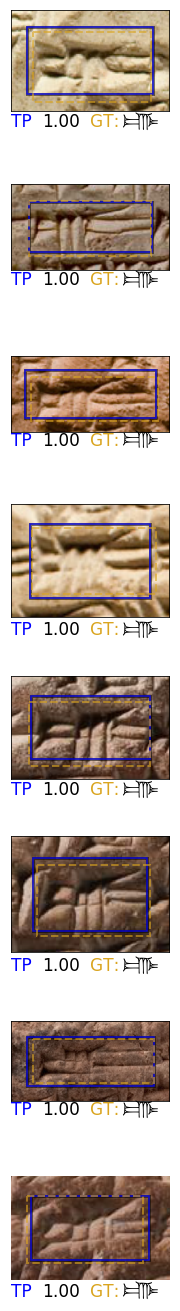

valid crops found: 7
False Positives(7) for class 𒌑[30]


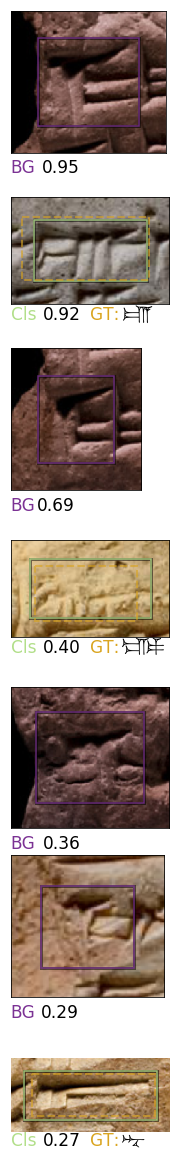

In [20]:
for sign_model_version in model_versions:
    print(sign_model_version)
    gen_fptp_visuals(relative_path, ds_version, src_used, detection_src, sign_model_version, classes_to_show,
                     lbl2lbl, num_classes, cunei_mzl_df, font_prop, apply_nms=apply_nms, nms_th=nms_th,
                     filter_completeness=False, compl_thresh=-1, ncompl_thresh=-1,
                     visualize_TPFP=visualize_TPFP, vis_score_th=vis_score_th, plot_TPFP_signs=plot_TPFP_signs, 
                     store_tfps_figures=store_tfps_figures, keep_only_placed=keep_only_placed, 
                     use_custom_list=use_custom_list, eval_tp_thresh=eval_tp_thresh, 
                     eval_bg_thresh=eval_bg_thresh, exp_name=exp_name, single_column=single_column)

<a id='results'>Results</a>

[Jump to config](#complconf)